In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle
from numpy.fft import fftshift,ifft
from scipy.signal import stft, windows

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
class MatrixClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(MatrixClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.fc1 = nn.Linear(128 * 16 * 64, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Precise: 0.1 VH

In [20]:
dataset_path = '../Dataset0.1/'

train_data_path = dataset_path + 'train/'
test_data_path = dataset_path + 'test/'


def load_pkl(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)
    
def rcs(echo):
    return 4*np.pi*np.abs(echo)**2

def awgn(signal, snr):
    # Calculate signal power and convert SNR to linear scale
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr / 10)
    
    # Calculate noise power and generate complex noise
    noise_power = signal_power / snr_linear
    noise_real = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise_imag = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise = noise_real + 1j * noise_imag
    
    # Add noise to the signal
    signal_with_noise = signal + noise
    
    return signal_with_noise

def STFT(st,nfft):
    winlen = 64
    _, _, Zxx = stft(st, fs=1024, window = windows.hamming(winlen), nperseg=winlen, nfft=nfft ,noverlap=winlen-1, boundary='zeros', return_onesided=False)
    return np.fft.fftshift(Zxx,axes=0)  

def normalize(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix  

def discrete(matrix, n=255):
    discrete_matrix = np.floor(matrix * n) / n
    return discrete_matrix  
    
# def data processing here.

def preprocessing(data, snr = None):
    polar_type = 'VH'
    E = awgn(data['echo'][polar_type],snr=snr)
    TFR = STFT(E, nfft = 128)
    data = discrete(normalize(np.abs(TFR)[:,:-1]))
    return data

def tensor_process(x, y):
    # x, y = transfer_device(x[1], y) # only use tfr.
    x = x.unsqueeze(1)
    return x, y 

class Dataset(Dataset):
    def __init__(self, dataset_dir, snr):
        self.snr = snr
        self.dataset_dir = dataset_dir
        self.instance_list = self.get_instance()
    
    def get_instance(self):
        instance_list = []
        for label in os.listdir(self.dataset_dir):
            label_dir = os.path.join(self.dataset_dir,label)
            label_list = glob.glob(label_dir+'/*.pkl')
            instance_list += label_list
        return instance_list

    def __len__(self):
        return len(self.instance_list)

    def __getitem__(self, idx):
        data = load_pkl(self.instance_list[idx])
        x = preprocessing(data, snr = self.snr)
        y = data['target_id']
        return x.astype(np.float32), y
        # return x,y
    
snr = 0
train_dataset = Dataset(train_data_path, snr = snr)
test_dataset = Dataset(test_data_path, snr = snr)

print(train_dataset.__len__(), test_dataset.__len__())

25200 1600


label is 0 (128, 512)


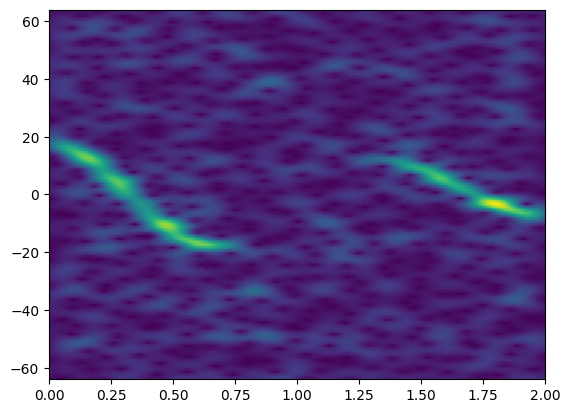

In [21]:
x,y = train_dataset.__getitem__(0)
print(f'label is {y}', x.shape)
plt.imshow(x, aspect = 'auto', extent = [0, 2, -64, 64]);

In [22]:
# # 参数设置
num_classes  = 4  # 类别数
model = MatrixClassifierCNN(num_classes).to(device)
num_epochs = 100
learning_rate = 0.001

# # 初始化模型、损失函数和优化器

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# def transfer_device(x,y):
#     # Move inputs and labels to the device if they are not already
#     if x.device != device:
#         x = x.to(device)
#     if y.device != device:
#         y = y.to(device)
#     return x,y

for x,y in train_loader:
    x,y = tensor_process(x, y)
    y = model(x.to(device))
    break

In [23]:
losses = {
    'train_loss': [],
    'val_loss': []
}


# Training loop with validation
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Training phase
    for x, y in train_loader:
        x, y = tensor_process(x, y)
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights
        
        running_loss += loss.item() * x.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == y).sum().item()
        total_predictions += y.size(0)

    # Calculate training loss and accuracy for the epoch
    epoch_loss = running_loss / total_predictions
    epoch_accuracy = correct_predictions / total_predictions * 100
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')

    # Store the training loss
    losses['train_loss'].append(epoch_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():  # No need to track gradients during validation
        for x_val, y_val in test_loader:
            x_val, y_val = tensor_process(x_val, y_val)
            x_val, y_val = x_val.to(device), y_val.to(device)
            
            # Forward pass
            outputs_val = model(x_val)
            loss_val = criterion(outputs_val, y_val)
            
            val_loss += loss_val.item() * x_val.size(0)
            _, predicted_val = torch.max(outputs_val, 1)
            val_correct_predictions += (predicted_val == y_val).sum().item()
            val_total_predictions += y_val.size(0)

    # Calculate validation loss and accuracy for the epoch
    val_epoch_loss = val_loss / val_total_predictions
    val_epoch_accuracy = val_correct_predictions / val_total_predictions * 100
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%')
    
        # Store the validation loss
    losses['val_loss'].append(val_epoch_accuracy)

# Save the loss data to a pickle file after each epoch
with open('loss_l_1.pkl', 'wb') as f:
    pickle.dump(losses, f)

Epoch [1/100], Training Loss: 0.7788, Training Accuracy: 64.56%
Epoch [1/100], Validation Loss: 0.7171, Validation Accuracy: 70.19%
Epoch [2/100], Training Loss: 0.4719, Training Accuracy: 80.99%
Epoch [2/100], Validation Loss: 0.5103, Validation Accuracy: 77.62%
Epoch [3/100], Training Loss: 0.3854, Training Accuracy: 84.92%
Epoch [3/100], Validation Loss: 0.4184, Validation Accuracy: 81.19%
Epoch [4/100], Training Loss: 0.3295, Training Accuracy: 87.21%
Epoch [4/100], Validation Loss: 0.4572, Validation Accuracy: 81.25%
Epoch [5/100], Training Loss: 0.2962, Training Accuracy: 88.58%
Epoch [5/100], Validation Loss: 0.4388, Validation Accuracy: 81.81%
Epoch [6/100], Training Loss: 0.2698, Training Accuracy: 89.63%
Epoch [6/100], Validation Loss: 0.5046, Validation Accuracy: 79.06%
Epoch [7/100], Training Loss: 0.2472, Training Accuracy: 90.75%
Epoch [7/100], Validation Loss: 0.4031, Validation Accuracy: 83.06%
Epoch [8/100], Training Loss: 0.2314, Training Accuracy: 91.17%
Epoch [8/100

# 0.01 VH

In [24]:
dataset_path = 'G:/Dataset0.01/'
train_data_path = dataset_path + 'train/'
test_data_path = dataset_path + 'test/'

snr = 0
train_dataset = Dataset(train_data_path, snr = snr)
test_dataset = Dataset(test_data_path, snr = snr)
print(train_dataset.__len__(), test_dataset.__len__())

# 参数设置
num_classes  = 4  # 类别数
model = MatrixClassifierCNN(num_classes).to(device)
num_epochs = 100
learning_rate = 0.001

# 初始化模型、损失函数和优化器

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

25200 1600


In [25]:
losses = {
    'train_loss': [],
    'val_loss': []
}


# Training loop with validation
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Training phase
    for x, y in train_loader:
        x, y = tensor_process(x, y)
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights
        
        running_loss += loss.item() * x.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == y).sum().item()
        total_predictions += y.size(0)

    # Calculate training loss and accuracy for the epoch
    epoch_loss = running_loss / total_predictions
    epoch_accuracy = correct_predictions / total_predictions * 100
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')

    # Store the training loss
    losses['train_loss'].append(epoch_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():  # No need to track gradients during validation
        for x_val, y_val in test_loader:
            x_val, y_val = tensor_process(x_val, y_val)
            x_val, y_val = x_val.to(device), y_val.to(device)
            
            # Forward pass
            outputs_val = model(x_val)
            loss_val = criterion(outputs_val, y_val)
            
            val_loss += loss_val.item() * x_val.size(0)
            _, predicted_val = torch.max(outputs_val, 1)
            val_correct_predictions += (predicted_val == y_val).sum().item()
            val_total_predictions += y_val.size(0)

    # Calculate validation loss and accuracy for the epoch
    val_epoch_loss = val_loss / val_total_predictions
    val_epoch_accuracy = val_correct_predictions / val_total_predictions * 100
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%')
    
        # Store the validation loss
    losses['val_loss'].append(val_epoch_accuracy)

# Save the loss data to a pickle file after each epoch
with open('loss_h_1.pkl', 'wb') as f:
    pickle.dump(losses, f)

Epoch [1/100], Training Loss: 1.1914, Training Accuracy: 41.00%
Epoch [1/100], Validation Loss: 0.7478, Validation Accuracy: 67.62%
Epoch [2/100], Training Loss: 0.7503, Training Accuracy: 68.98%
Epoch [2/100], Validation Loss: 0.5654, Validation Accuracy: 77.50%
Epoch [3/100], Training Loss: 0.5671, Training Accuracy: 77.03%
Epoch [3/100], Validation Loss: 0.3851, Validation Accuracy: 84.56%
Epoch [4/100], Training Loss: 0.4734, Training Accuracy: 81.09%
Epoch [4/100], Validation Loss: 0.3858, Validation Accuracy: 84.75%
Epoch [5/100], Training Loss: 0.4089, Training Accuracy: 84.05%
Epoch [5/100], Validation Loss: 0.3266, Validation Accuracy: 87.31%
Epoch [6/100], Training Loss: 0.3738, Training Accuracy: 85.54%
Epoch [6/100], Validation Loss: 0.4368, Validation Accuracy: 84.12%
Epoch [7/100], Training Loss: 0.3393, Training Accuracy: 86.88%
Epoch [7/100], Validation Loss: 0.3115, Validation Accuracy: 87.12%
Epoch [8/100], Training Loss: 0.3077, Training Accuracy: 87.99%
Epoch [8/100